In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
import itertools
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [9]:

training_data = torchvision.datasets.MNIST("./", train=True,
            transform=torchvision.transforms.ToTensor(), download=True)
testing_data = torchvision.datasets.MNIST("./", train=False,
            transform=torchvision.transforms.ToTensor(), download=True)
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size)

In [4]:
# use cpu or gpu device if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

encoding_dim = 2

# Define encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(28*28, 200)
        self.linear2 = nn.Linear(200, 50)
        self.linear3_mu = nn.Linear(50,encoding_dim)
        self.linear3_sd = nn.Linear(50,encoding_dim)
        
    def forward(self, x_in):
        x = self.flatten(x_in)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        mu = self.linear3_mu(x)
        logvar = self.linear3_sd(x)
        return mu, logvar
    
# Define decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(encoding_dim, 50)
        self.linear2 = nn.Linear(50, 200)
        self.linear3 = nn.Linear(200, 28*28)
        self.relu = nn.ReLU()
        self.unflatten = nn.Unflatten(1, (1, 28, 28))

    def forward(self, x_in):
        x = self.relu(self.linear1(x_in))
        x = self.relu(self.linear2(x))
        x = self.unflatten(self.linear3(x))
        return x

decoder = Decoder().to(device)
encoder = Encoder().to(device)

loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()) , lr=1e-3) 

Using cpu device


In [5]:
encoder.load_state_dict(torch.load("encoder_dict.pt", map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load("decoder_dict.pt",map_location=torch.device('cpu')))

C:\Users\jnloz\AppData\Local\Temp\ipykernel_13328\2957488607.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("encoder_dict.pt", map_lo

<All keys matched successfully>

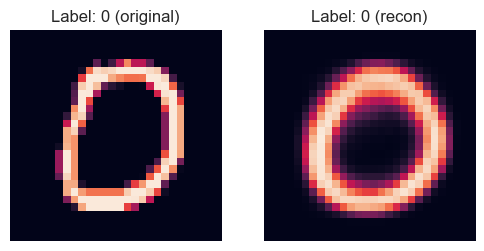

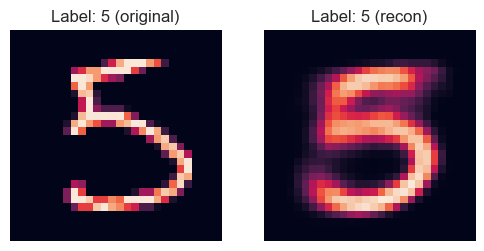

In [207]:
from torch.utils.data import Subset

selections = [10,15]
subset = Subset(testing_data,selections)
subdataloader = DataLoader(subset, batch_size=2, shuffle=False)

with torch.no_grad():
    for batch, (X, y) in enumerate(subdataloader):
        X, y = X.to(device),y.to(device)

        encoded_mu, encoded_logvar = encoder(X)
        z = encoded_mu + torch.randn_like(encoded_logvar)*torch.exp(encoded_logvar/2.0)
        decoded = decoder(z)

        for i in range(X.size(0)):
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))  

            # Original
            axes[0].imshow(X[i,:,:,:].cpu().permute(1, 2, 0).squeeze())
            axes[0].set_title(f"Label: {y[i].item()} (original)")
            axes[0].axis('off')

            # Reconstruction
            axes[1].imshow(torch.sigmoid(decoded[i,:,:,:]).cpu().permute(1, 2, 0).squeeze())
            axes[1].set_title(f"Label: {y[i].item()} (recon)")
            axes[1].axis('off')
            plt.show()
        break


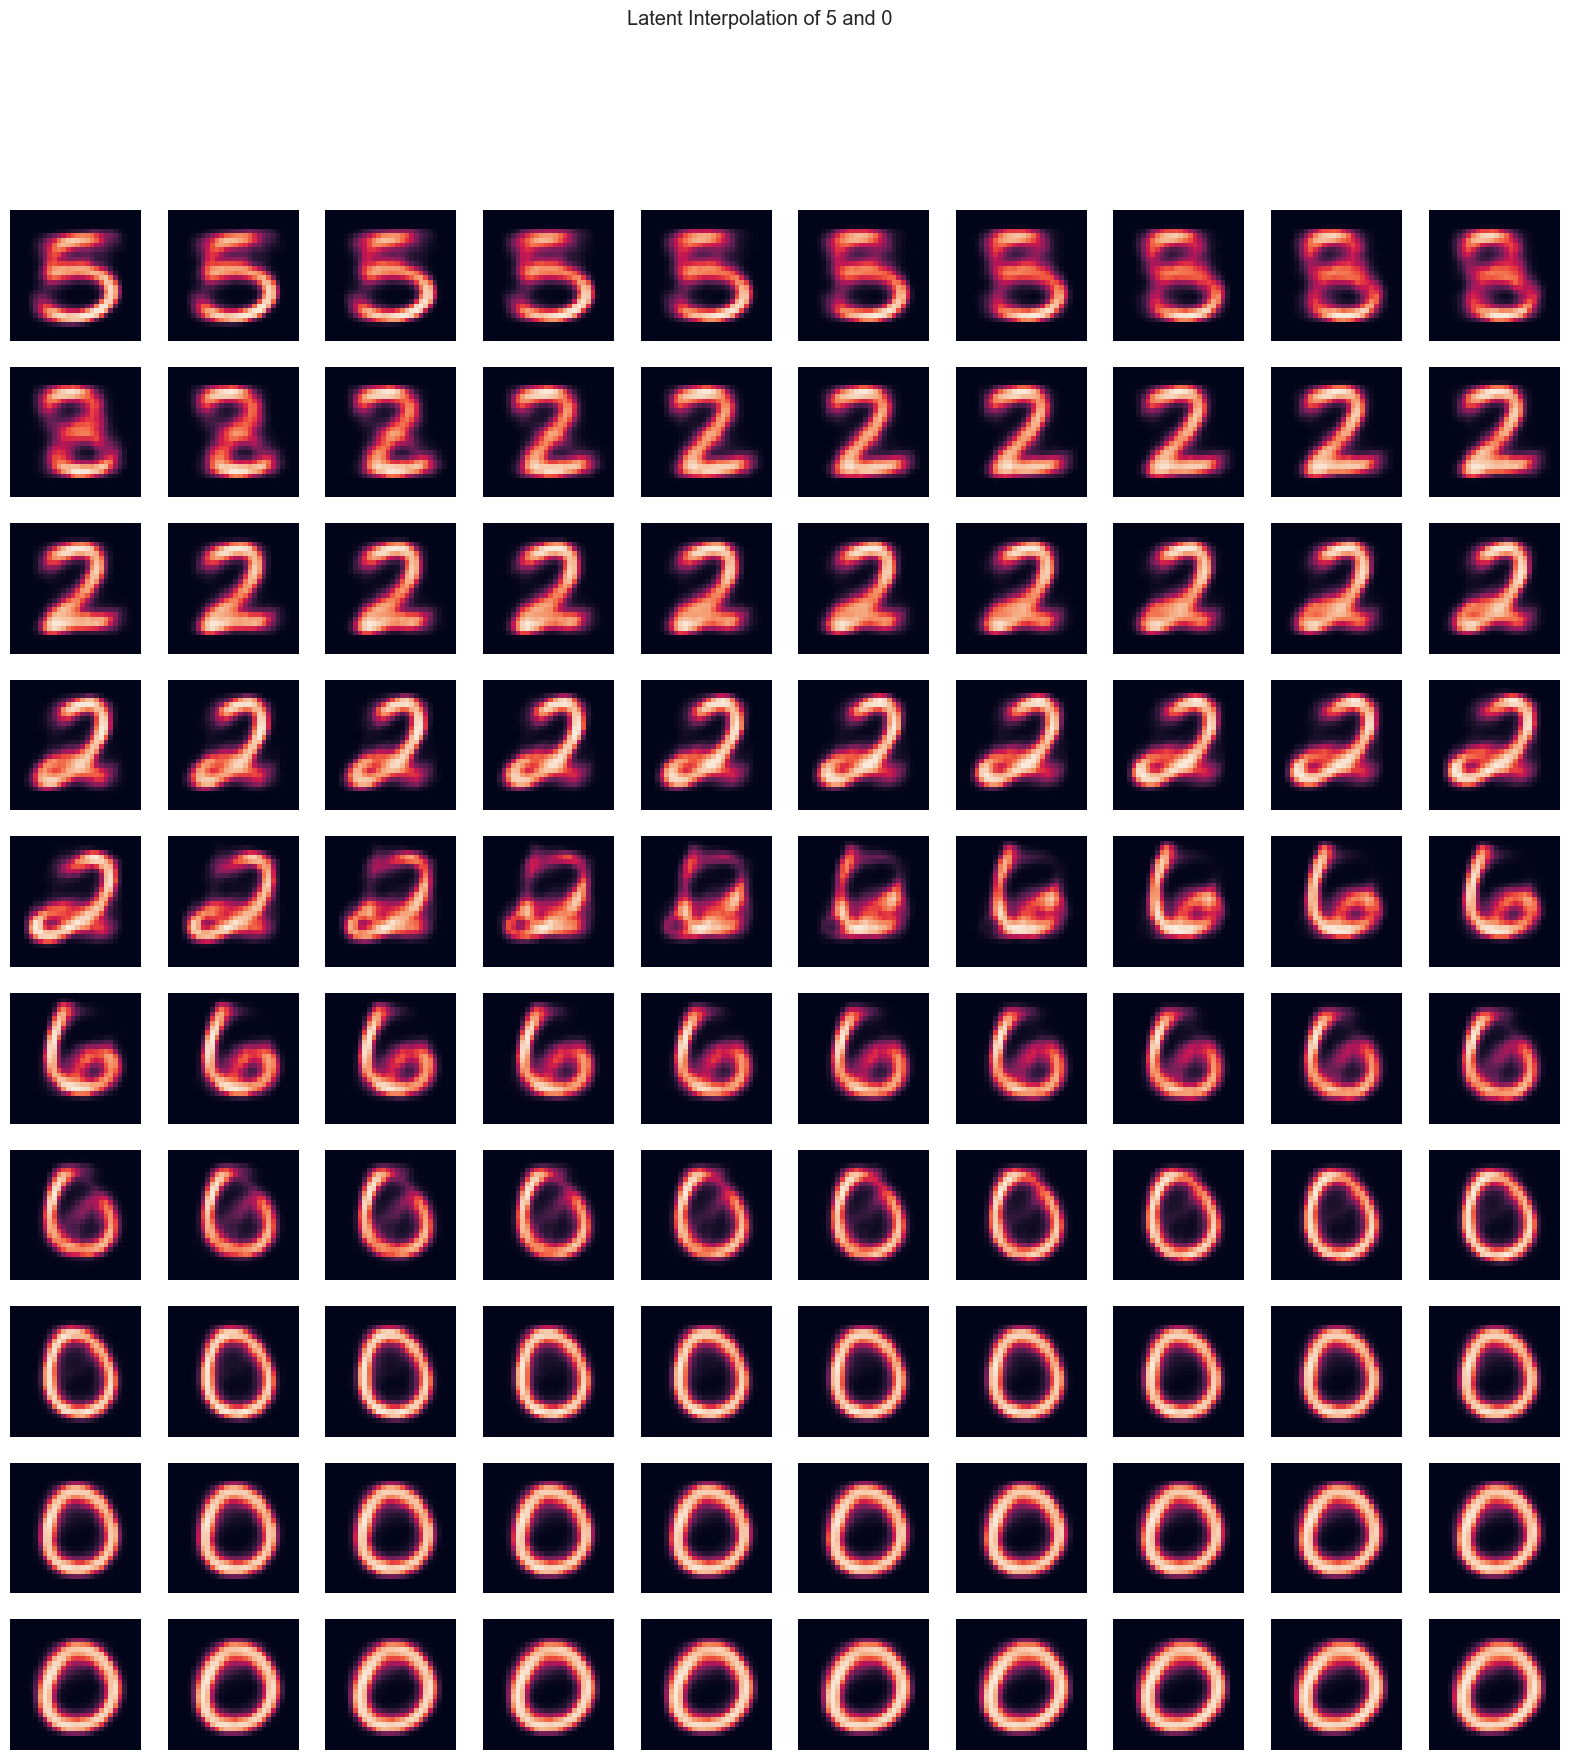

In [208]:
a = torch.linspace(0,1,100)

def makeLine(z1,z2,a):
    return(a*z1 + (1-a)*z2)

with torch.no_grad():
    for batch, (X, y) in enumerate(subdataloader):
        X, y = X.to(device),y.to(device)

        encoded_mu, encoded_logvar = encoder(X)
        z = encoded_mu + torch.randn_like(encoded_logvar)*torch.exp(encoded_logvar/2.0)
        z1,z2 = z[0],z[1]
        newZ = torch.stack([makeLine(z1, z2, alpha) for alpha in a]) #got torch.stack from google
        
        decoded = decoder(newZ)
        
        fig, axes = plt.subplots(10, 10, figsize=(20, 20))

        for i, ax in enumerate(axes.flat):
            ax.imshow(torch.sigmoid(decoded[i,:,:,:]).cpu().permute(1, 2, 0).squeeze())
            ax.axis('off')

        plt.suptitle(f"Latent Interpolation of {y[1]} and {y[0]}")
        plt.show()

        break